# Fine-Tune ViT for Vehicle Image Classification with Hugging Face Transformers 🤗

### Downlaoding the dataset from roboflow

In [1]:
from roboflow import Roboflow
import os
if not os.path.exists("./Vehicle-Classification-1/"): 
    rf = Roboflow(api_key="QcgQPG8g2tj3r0ottt5l")
    project = rf.workspace("paul-guerrie-tang1").project("vehicle-classification-eapcd")
    dataset = project.version(1).download("folder")

### Importing all the required packages

In [2]:
import torch
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import DataLoader
from transformers import ViTFeatureExtractor, ViTForImageClassification, ViTImageProcessor
import tqdm as notebook_tqdm
import pytorch_lightning as pl
from torchmetrics import Accuracy

import warnings
warnings.filterwarnings('ignore')

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


### Loading the data

In [13]:
# Assigning device based on windows or macOS
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print("Running on", device)

Running on mps


In [14]:
data_dir = Path('Vehicle-Classification-1')
train_data_dir = Path('Vehicle-Classification-1/train')
val_data_dir = Path('Vehicle-Classification-1/valid')
test_data_dir = Path('Vehicle-Classification-1/test')
ds = ImageFolder(data_dir)

# the training transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    transforms.RandomRotation(degrees=(30, 70)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])

# the validation transforms
valid_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])

#train_ds = ImageFolder(train_data_dir, transform = train_transform)
#val_ds = ImageFolder(val_data_dir, transform = valid_transform)

train_ds = ImageFolder(train_data_dir)
val_ds = ImageFolder(val_data_dir)
test_ds = ImageFolder(test_data_dir)

### Showing some examples for each category in vehicle dataset

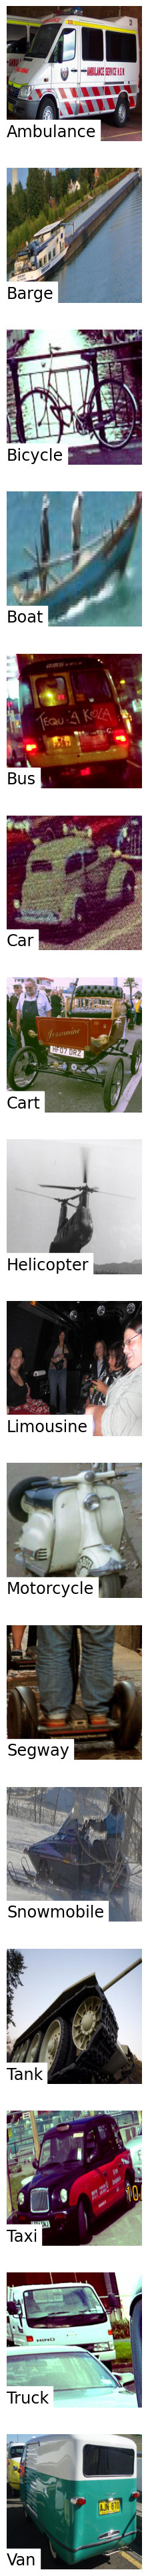

In [15]:
plt.figure(figsize=(10,50))
num_examples_per_class = 1
i = 1
for class_idx, class_name in enumerate(train_ds.classes):
    folder = train_ds.root / class_name
    for image_idx, image_path in enumerate(sorted(folder.glob('*'))):
        if image_path.suffix in ds.extensions:
            image = Image.open(image_path)
            plt.subplot(len(train_ds.classes), num_examples_per_class, i)
            ax = plt.gca()
            ax.set_title(
                class_name,
                size='xx-large',
                pad=5,
                loc='left',
                y=0,
                backgroundcolor='white'
            )
            ax.axis('off')
            plt.imshow(image)
            i += 1

            if image_idx + 1 == num_examples_per_class:
                break

In [16]:
# # Define a transform to convert PIL 
# # image to a Torch tensor
# transform = transforms.Compose([
#     transforms.PILToTensor()
# ])
  

# # Trying to send input to device
# for class_idx, class_name in enumerate(train_ds.classes):
#     folder = train_ds.root / class_name
#     for image_idx, image_path in enumerate(sorted(folder.glob('*'))):
#         if image_path.suffix in ds.extensions:
#             image = Image.open(image_path)
#             # transform = transforms.PILToTensor()
#             # Convert the PIL image to Torch tensor
#             image = transform(image)
#             image = image.to(device)

# # Trying to send input to device
# for class_idx, class_name in enumerate(val_ds.classes):
#     folder = val_ds.root / class_name
#     for image_idx, image_path in enumerate(sorted(folder.glob('*'))):
#         if image_path.suffix in ds.extensions:
#             image = Image.open(image_path)
#             # transform = transforms.PILToTensor()
#             # Convert the PIL image to Torch tensor
#             image = transform(image)
#             image = image.to(device)

### Preparing Labels for Our Model's Config

In [17]:
label2id = {}
id2label = {}

for i, class_name in enumerate(train_ds.classes):
    label2id[class_name] = str(i)
    id2label[str(i)] = class_name

In [18]:
label2id

{'Ambulance': '0',
 'Barge': '1',
 'Bicycle': '2',
 'Boat': '3',
 'Bus': '4',
 'Car': '5',
 'Cart': '6',
 'Helicopter': '7',
 'Limousine': '8',
 'Motorcycle': '9',
 'Segway': '10',
 'Snowmobile': '11',
 'Tank': '12',
 'Taxi': '13',
 'Truck': '14',
 'Van': '15'}

In [19]:
id2label

{'0': 'Ambulance',
 '1': 'Barge',
 '2': 'Bicycle',
 '3': 'Boat',
 '4': 'Bus',
 '5': 'Car',
 '6': 'Cart',
 '7': 'Helicopter',
 '8': 'Limousine',
 '9': 'Motorcycle',
 '10': 'Segway',
 '11': 'Snowmobile',
 '12': 'Tank',
 '13': 'Taxi',
 '14': 'Truck',
 '15': 'Van'}

### Image Classification Collator

In [20]:
class ImageClassificationCollator:
    def __init__(self, feature_extractor):
        self.feature_extractor = feature_extractor
 
    def __call__(self, batch):
        encodings = self.feature_extractor([x[0] for x in batch], return_tensors='pt')
        encodings['labels'] = torch.tensor([x[1] for x in batch], dtype=torch.long)
        encodings['labels'] = encodings['labels'].to(device)
        return encodings

### Init Feature Extractor, Data Loaders

In [34]:
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')

collator = ImageClassificationCollator(feature_extractor)

train_loader = DataLoader(train_ds, batch_size=256, collate_fn=collator, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=256, collate_fn=collator, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=8, collate_fn=collator, shuffle=True)

In [36]:
class Classifier(pl.LightningModule):

    def __init__(self, model, lr: float = 2e-5, **kwargs):
        super().__init__()
        self.save_hyperparameters('lr', *list(kwargs))
        self.model = model
        self.forward = self.model.forward
        self.val_acc = Accuracy(
            task='multiclass' if model.config.num_labels > 2 else 'binary',
            num_classes=model.config.num_labels
        )

    def training_step(self, batch, batch_idx):
        outputs = self(**batch)
        self.log(f"train_loss", outputs.loss)
        return outputs.loss

    def validation_step(self, batch, batch_idx):
        outputs = self(**batch)
        self.log(f"val_loss", outputs.loss)
        acc = self.val_acc(outputs.logits.argmax(1), batch['labels'])
        self.log(f"val_acc", acc, prog_bar=True)
        return outputs.loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)

### Building, Training and Evaluating the Models

**Model 1: Freezing the body layers and training the head layers**

In [35]:
# Building or Loading the model
if os.path.exists('./models/head_trained.pt'):
    if torch.backends.mps.is_available():
        model = torch.load('./models/head_trained.pt', map_location ='mps')
    elif torch.cuda.is_available():
        model = torch.load('./models/head_trained.pt')
    else:
        model = torch.load('./models/head_trained.pt', map_location ='cpu')
else:
    model = ViTForImageClassification.from_pretrained(
        'google/vit-base-patch16-224-in21k',
        num_labels=len(label2id),
        label2id=label2id,
        id2label=id2label
    )
# Freezing main body layers
for p in model.vit.parameters():
    p.requires_grad = False

model = model.to(device)

In [37]:
# Training the model
if not os.path.exists('./models/head_trained.pt'):
    pl.seed_everything(42)

    classifier = Classifier(model, lr=2e-5)

    if torch.cuda.is_available():
        trainer = pl.Trainer(accelerator='cuda', devices=1, precision='bf16-mixed', max_epochs=50)
    elif torch.backends.mps.is_available():
        trainer = pl.Trainer(accelerator='mps', devices=1, precision='bf16-mixed', max_epochs=50)
    else:
        trainer = pl.Trainer(accelerator='cpu', devices=1, precision='bf16-mixed', max_epochs=50)

    trainer.fit(classifier, train_loader, val_loader)
    torch.save(model,'./models/head_trained.pt')

In [38]:
# Creating a function to calculate the accuracy of model
def check_accuracy(test_loader: DataLoader, model, device):
    num_correct = 0
    total = 0
    model.eval()
    model.to(device)
    with torch.no_grad():
        for batch in test_loader:
            
            data = batch['pixel_values'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(data)
            predictions = outputs.logits.softmax(1).argmax(1)

            num_correct += (predictions == labels).sum()
            total += labels.size(0)

        print(f"Test Accuracy of the model: {float(num_correct)/float(total)*100:.2f}")

In [32]:
# Evaluating the model
check_accuracy(test_loader, model, device)

Test Accuracy of the model: 66.46


**Model 2: Training the last layers**

In [39]:
for p in model.vit.layernorm.parameters():
    p.requires_grad = True
for layer in model.vit.encoder.layer:
    for p in layer.layernorm_after.parameters():
        p.requires_grad = True
for layer in model.vit.encoder.layer:
    for p in layer.layernorm_after.parameters():
        p.requires_grad = True

In [42]:
# Training the model
if os.path.exists('./models/last_layers_trained.pt'):
    if torch.backends.mps.is_available():
        model = torch.load('./models/last_layers_trained.pt', map_location ='mps')
    elif torch.cuda.is_available():
        model = torch.load('./models/last_layers_trained.pt')
    else:
        model = torch.load('./models/last_layers_trained.pt', map_location='cpu')
else:
    model.train()

    train_loader = DataLoader(train_ds, batch_size=8, collate_fn=collator, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=8, collate_fn=collator, shuffle=True)

    pl.seed_everything(42)

    classifier = Classifier(model, lr=2e-5)
    
    if torch.cuda.is_available():
        trainer = pl.Trainer(accelerator='cuda', devices=1, precision='bf16-mixed', max_epochs=10)
    elif torch.backends.mps.is_available():
        trainer = pl.Trainer(accelerator='mps', devices=1, precision='bf16-mixed', max_epochs=10)
    else:
        trainer = pl.Trainer(accelerator='cpu', devices=1, precision='bf16-mixed', max_epochs=10)
    
    trainer.fit(classifier, train_loader, val_loader)
    torch.save(model,'./models/last_layers_trained.pt')

In [43]:
# Evaluating the model
check_accuracy(test_loader, model, device)

Test Accuracy of the model: 67.51


**Model 3: Training with all the layers**

In [44]:
for p in model.parameters():
    p.requires_grad = True

In [46]:
# Training the model
if os.path.exists('./models/full_model_trained.pt'):
    if torch.backends.mps.is_available():
        model = torch.load('./models/full_model_trained.pt', map_location ='mps')
    elif torch.cuda.is_available():
        model = torch.load('./models/full_model_trained.pt')
    else:
        model = torch.load('./models/full_model_trained.pt', map_location='cpu')
else:
    torch.set_float32_matmul_precision('medium')
    model.train()

    train_loader = DataLoader(train_ds, batch_size=8, collate_fn=collator, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=8, collate_fn=collator, shuffle=True)
    
    pl.seed_everything(42)
    
    classifier = Classifier(model, lr=2e-5)
    
    if torch.cuda.is_available():
        trainer = pl.Trainer(accelerator='cuda', devices=1, precision='bf16-mixed', max_epochs=10)
    elif torch.backends.mps.is_available():
        trainer = pl.Trainer(accelerator='mps', devices=1, precision='bf16-mixed', max_epochs=10)
    else:
        trainer = pl.Trainer(accelerator='cpu', devices=1, precision='bf16-mixed', max_epochs=10)
    
    trainer.fit(classifier, train_loader, val_loader)
    torch.save(model,'./models/full_model_trained.pt')

In [47]:
# Evaluating the model
check_accuracy(test_loader, model, device)

Test Accuracy of the model: 67.76


**Model 4: Training the model without freezing any layer**

In [48]:
# Building or Loading the model
if os.path.exists('./models/all_layers_model.pt'):
    if torch.backends.mps.is_available():
        model = torch.load('./models/all_layers_model.pt', map_location ='mps')
    elif torch.cuda.is_available():
        model = torch.load('./models/all_layers_model.pt')
    else:
        model = torch.load('./models/all_layers_model.pt', map_location ='cpu')
else:
    model = ViTForImageClassification.from_pretrained(
        'google/vit-base-patch16-224-in21k',
        num_labels=len(label2id),
        label2id=label2id,
        id2label=id2label
    )

model = model.to(device)

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [49]:
# Training the model
if not os.path.exists('./models/all_layers_model.pt'):
    pl.seed_everything(42)

    classifier = Classifier(model, lr=2e-5)

    if torch.cuda.is_available():
        trainer = pl.Trainer(accelerator='cuda', devices=1, precision='bf16-mixed', max_epochs=50)
    elif torch.backends.mps.is_available():
        trainer = pl.Trainer(accelerator='mps', devices=1, precision='bf16-mixed', max_epochs=50)
    else:
        trainer = pl.Trainer(accelerator='cpu', devices=1, precision='bf16-mixed', max_epochs=50)

    trainer.fit(classifier, train_loader, val_loader)
    torch.save(model,'./models/all_layers_model.pt')

Global seed set to 42
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type                      | Params
------------------------------------------------------
0 | model   | ViTForImageClassification | 85.8 M
1 | val_acc | MulticlassAccuracy        | 0     
------------------------------------------------------
85.8 M    Trainable params
0         Non-trainable params
85.8 M    Total params
343.244   Total estimated model params size (MB)


Epoch 0:   0%|          | 0/76 [00:00<?, ?it/s]                            

RuntimeError: MPS backend out of memory (MPS allocated: 6.44 GB, other allocations: 2.60 GB, max allowed: 9.07 GB). Tried to allocate 147.75 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

In [ ]:
# Evaluating the model
check_accuracy(test_loader, model, device)